# Northwind Statistical Tests
George Bennett

In this project I will be answering four questions about the Northwind database using statistical tests: <br>
* Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
* Do different shippers have different freight costs?
* Is there a statistically significant difference in demand of produce each month?
* Do products in the Meat/Poultry category have a higher unit price than products in the Seafood category?

To begin this project I will import necessary libraries and take a look at the database's table names and the database ERD

Import Libraries

In [2]:
# import libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

Here I will create a connection to the database

In [3]:
# create a connection to the data base
conn = sqlite3.connect("Northwind_small.sqlite")
# create a cursor
c = conn.cursor()

Now I will take a look at the table names

In [4]:
# query string for selecting table names
query = """
SELECT name FROM sqlite_master WHERE type = "table"
"""
# execute query
c.execute(query).fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

Here is the ERD I was given for the dataset

<img src="Northwind_ERD_updated.png">

## Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

To answer this question I will need to first obtain the data. I will query from the OrderDetail table. The Columns I need from OrderDetail are Quantity and Discount. Finally I will put the data into a pandas DataFrame.

In [5]:
# query
query = """
SELECT Quantity, Discount FROM OrderDetail
"""
# execute query and put the data in a dataframe
df = pd.DataFrame(c.execute(query).fetchall())
# set column names
df.columns = [x[0] for x in c.description]
# preview
df.head(3)

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0


Next I will compare orders with a discount to orders without a discount. To do this I will use a T-test. In order to deturmine which type of T-test to use I will first test if the variance's of the two samples are significantly different using a Levene test. Before I perform the tests I need to make sure the group's quantity values are normally distributed. I will check this assumption with QQ-plots and histograms.

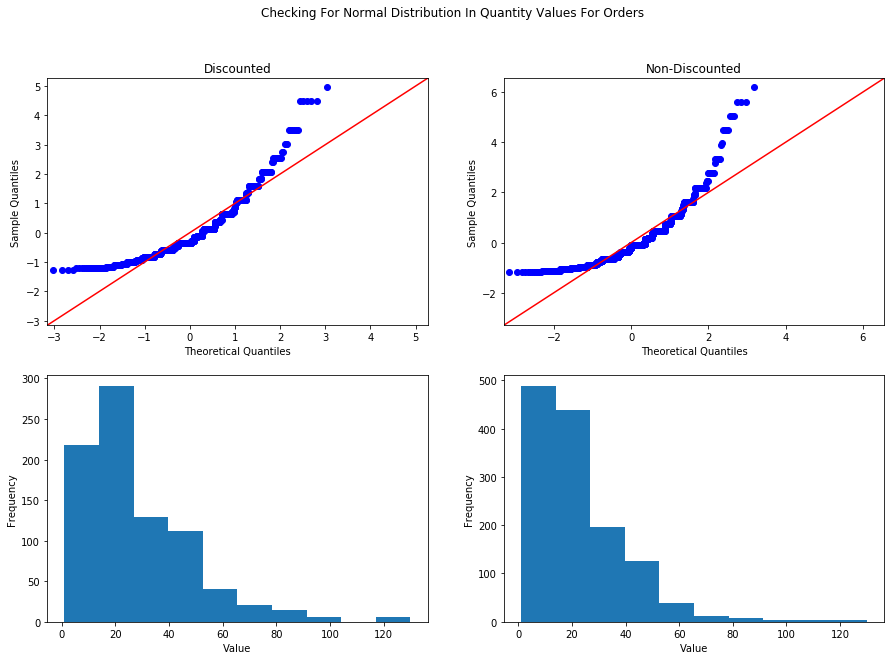

In [29]:
# Seperate Discounted Orders from Non-Discounted Orders
discounted = df[df['Discount'] > 0]['Quantity']
non_discounted = df[df['Discount'] == 0]['Quantity']
# define function for checking normality
def normality_plots(data1, data2, main_title, subtitle1, subtitle2):
    """
    check normality of two samples using QQ-plots and histograms
    """
    # subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(main_title)
    # discounted
    qqplot(data1, ax=ax1, fit=True, line='45')
    ax1.set_title(subtitle1)
    ax3.hist(data1)
    # non_discounted
    qqplot(data2, ax=ax2, fit=True, line='45')
    ax2.set_title(subtitle2)
    ax4.hist(data2)
    # set axis labels for histograms
    for ax in [ax3, ax4]:
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    # display
    plt.show()
    return None
# call function
main_title = 'Checking For Normal Distribution In Quantity Values For Orders'
subtitle1 = 'Discounted'
subtitle2 = 'Non-Discounted'
_ = normality_plots(discounted, non_discounted, main_title, subtitle1, subtitle2)

Since the samples' values are not normally distributed I will take advantage of the central limit theorem and create data sets out of the means of samples from the two groups. I will then perform the tests on these resampled data sets since they ensured to follow a normal distribution.

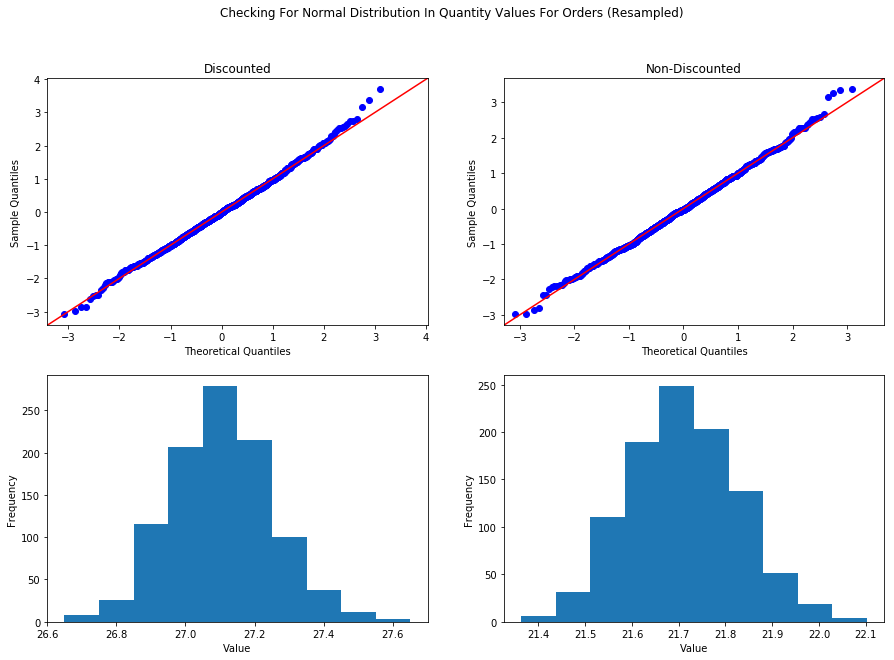

In [31]:
# create function for using central limit theorem
def get_resampled_means(data, sample_size=100, n_samples=1000):
    """
    Used to get a version of the data that is normally distributed with the help
    of the central limit theorem. Takes random samples with replacement from the dataset
    and then collects the mean of each sample to form a new dataset.
    """
    # create a list to store means
    collected_means=[]
    # get a sample n-times
    for n in range(n_samples):
        random_sample = np.random.choice(data, size=sample_size, replace=True)
        # store the mean for each sample
        collected_means.append(random_sample.mean())
    # return the means as an array
    return np.array(collected_means)
# apply function
#size1 = len(discounted_resampled) // 5
discounted_resampled = get_resampled_means(discounted, size1)
#size2 = len(non_discounted_resampled) // 5
non_discounted_resampled = get_resampled_means(non_discounted, size2)
# check again for normality
main_title2 = 'Checking For Normal Distribution In Quantity Values For Orders (Resampled)'
_ = normality_plots(discounted_resampled, non_discounted_resampled, main_title2, subtitle1, subtitle2)

Now I will perform the Levene Test to see if the variances of the two groups are significantly different. I will be using the commonly used alpha value of 0.05 as my cutoff point for making my decision. If the P-value returned from the test is below that threshold I may reject the null hypothesis.
## Levene Test
* Null Hypothesis: The variances of the quantity values for the resampled discounted and non-discounted orders datasets are NOT significantly different
* Alternative Hypothesis: The variances of the quantity values for the resampled discounted and non-discounted orders datasets ARE significantly different
* Alpha Value: 0.05

In [32]:
# levene test
stats.levene(discounted_resampled, non_discounted_resampled)

LeveneResult(statistic=45.10508849855395, pvalue=2.4263697508864737e-11)

The P-value is below the alpha threshold, which means I will reject the null hypothesis and assume the datasets have significantly different variances. Taking this into account I will use a Welch's T-test to answer the original question: "Are the quantities significantly different".
## Welch's T-test
* Null Hypothesis: There is NOT a statistical significant difference in the quantity values for the resampled datasets of discounted and non-discounted orders.
* Alternative Hypothesis: There IS a statistical significant difference in the quantity values for the resampled datasets of discounted and non-discounted orders.
* Alpha Value: 0.05

In [33]:
# welch's T-test
stats.ttest_ind(discounted_resampled, non_discounted_resampled, equal_var=False)

Ttest_indResult(statistic=904.6190811172262, pvalue=0.0)

The P-value yis below the alpha value so I will reject the null hypothesis. The answer to the first part of question 1 is <strong>yes</strong>, there is a statistically significant difference in the quantity values for discounted and non-discounted orders. This suggests that giving someone a discount will likely influence that person to purchase more of the product.